# Lesson 4 Assignment - Automobile Price Hypothesis Testing
## Author - Aeden Jameson

### Instructions
Test hypotheses for the price of automobiles:

1. Compare and test the normality of the distributions of **price** and **log price**. <br/>
Use both a graphical method and a formal test. Hint: remember these relationships will always be approximate.

2. Test significance of **price (or log price)** stratified by 
a) **fuel type**, b) **aspiration**, and c) **rear vs. front wheel drive**. <br />Use both graphical methods and the formal test.

3. Apply ANOVA and Tukey's HSD test to the auto price data to compare the **price (or log price** if closer to a normal distribution) of autos stratified by **body style**.

4. Graphically explore the differences between the price conditioned by the categories of each variable. <br/>
Hint: Make sure you have enough data for each category and drop categories with insufficient data.

5. Use standard ANOVA and Tukey HSD to test the differences of these groups.


#### Note: 
Please clearly outline the results of these tests with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

## Prepare & Load Data

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import sklearn.preprocessing as sk
from statistics import mean
import statsmodels.stats.weightstats as ws
%matplotlib inline


def read_auto_data(fileName = "Automobile price data _Raw_.csv"):
    'Function to load the auto price data set from a .csv file' 
    import pandas as pd
    import numpy as np

    ## Read the .csv file with the pandas read_csv method
    auto_price = pd.read_csv(fileName)
    
    ## Remove rows with missing values, accounting for mising values coded as '?'
    cols = ['price', 'bore', 'stroke', 
          'horsepower', 'peak-rpm']
    for column in cols:
        auto_price.loc[auto_price[column] == '?', column] = np.nan
    auto_price.dropna(axis = 0, inplace = True)

    ## Convert some columns to numeric values
    for column in cols:
        auto_price[column] = pd.to_numeric(auto_price[column])
        
    return auto_price

fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"
auto_prices = read_auto_data(fileName)

## Step 1: Test Data for Normality

To start off we will look at a simple histogram of our data to get a feel for the shape. 

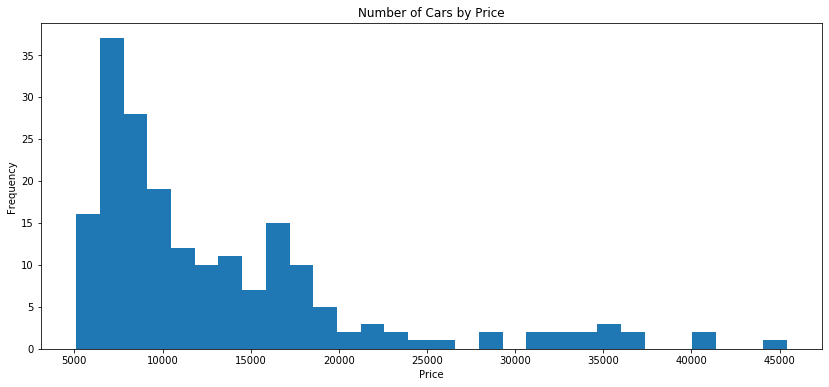

In [3]:
fig = plt.figure(figsize=(14,6)) # define plot area
ax = fig.gca() # define axis    
ax.set_title('Number of Cars by Price') # Give the plot a main title
ax.set_xlabel('Price') # Set text for the x axis
auto_prices.loc[:,'price'].plot.hist(bins = 30, ax = ax);

#### Observation:

  Since price is defined in a range 0 < p < inf, the distribution of above is fairly skewed, with a fairly low mean and high variance this suggests that perhaps our price random variable follows a log normal distribution. Next we'll do a Q-Q plot of both the origial prices and the log of the prices.

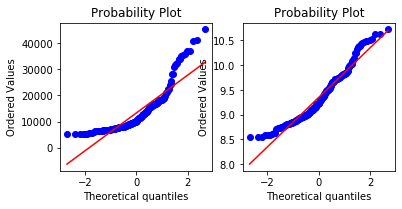

In [4]:
def qq_plot(vec1, vec2):
    plt.figure(figsize=(6, 6)).gca() # define axis
    ax1 = plt.subplot(221) ## setup the left subplot
    ss.probplot(vec1, plot = ax1) ## Plot the left subplot
    ax2 = plt.subplot(222) ## Set up the right subplot
    ss.probplot(vec2, plot = ax2) ## Plot the right subplot

qq_plot(sorted(auto_prices.loc[:,"price"].tolist()), sorted(np.log(auto_prices.loc[:,"price"].tolist())))  



As we can see in the plot on the right with the tranformed prices lie along the straight line except for at the ends.

### Kolmogorov-Smirnov Test 

Before performing the formal K-S test let's investigate the CDF's of the normalized auto prices and a theoretical standard normal since the test gives the maximum vertical distance between the respective CDF's. If visually they don't look quite close there would be no reason to bother with a formal test.

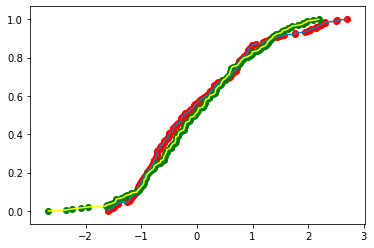

In [4]:
def plot_cums(dist1, dist2):
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)

    # Now plot as line and scatter plot. 
    plt.plot(data_sorted, p)
    plt.scatter(data_sorted, p, color = 'red')
    
    # sort the seond data sample:
    data_sorted = np.sort(dist2)
    
    # And the second plot
    plt.plot(data_sorted, p, color = 'yellow')
    plt.scatter(data_sorted, p, color = 'green')


norm_dist = np.random.normal(size = 195).tolist()
normalized_prices = sk.scale(np.log10(auto_prices.loc[:,"price"]))
plot_cums(normalized_prices, norm_dist)    

As we can see the CDF's of the normalized auto prices and a theoretical standard normal are quite close. Now let's perform a formal K-S test.

In [5]:
from scipy.stats import kstest 
ks_statisic, pvalue = kstest(normalized_prices, 'norm')
print('KS-statistic = ' + str(ks_statisic))
print('P-value = ' + str(pvalue));

KS-statistic = 0.1029553721679255
P-value = 0.029757993611013965


#### Conclusion

The K-S statistic is large and the p-value is quite small that is less than .05. It appears that we can reject the null hypothesis and conclude our car prices random variable was drawn from a normal distribution.

## Step 2: Test Significance 

**Null Hypothesis:** There is not a significant difference in the mean price of diesel and gas cars.

**Alternative Hypothesis:** There is a significant difference in the mean price of diesel and gas cars.

**Cutoff:** 0.05

### Case: Price grouped by fuel type

#### Graphical Spot Check

We can take quick look at a box plot to get a general idea of the relative difference in means as well as other things like the spread of the values and outliers.

In [6]:
# take a stratified sample. there are only 20 diesel cars so let's just take 20 gas
diesel_cars_sample = auto_prices.loc[auto_prices['fuel-type'] == 'diesel']
gas_cars_sample = auto_prices.loc[auto_prices['fuel-type'] == 'gas'].sample(n=20)
total_sample = diesel_cars_sample.append(gas_cars_sample)

(0.0, 50000.0)

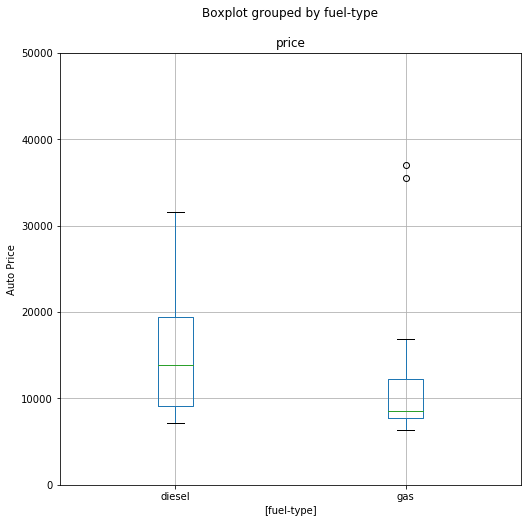

In [7]:
fig = plt.figure(figsize=(8, 8)) # define plot area
ax = fig.gca() # define axis 
total_sample.loc[:,['price', 'fuel-type']].boxplot(by = 'fuel-type', ax = ax)
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

As we can see the means are pretty far apart, but are they far enough apart as to be significant? Let's explore this formally.

#### The T-Test

Let's not assume equal variance in prices of diesel and gas cars. Therefore, we'll use Welch's t-test.

In [8]:
def t_test(a, b, alpha, alternative='two-sided', usevar = 'unequal'):
    '''Function to compute a two sample t-test on means'''
    
    ## Compute the difference in means for reporting.
    diff = a.mean() - b.mean()

    ## Compute the t-test
    t, p, df = ws.ttest_ind(a, b, usevar=usevar)
    
    ## Find the confidence interval
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar=usevar) 

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([df, diff, t, p, confint[0], confint[1]], index = index)  
   

t_test_price_by_fuel = t_test(diesel_cars_sample.loc[:,'price'], gas_cars_sample.loc[:,'price'], 0.05)
t_test_price_by_fuel

DegFreedom      37.458389
Difference    3434.400000
Statistic        1.312740
PValue           0.197257
Low95CI      -1864.351867
High95CI      8733.151867
dtype: float64

We can make a few observations from the stastics above:

1. **Difference in means** is large.
2. **t-statistic is large and the p-value is very small**. There is a high chance that the difference in means is **significant**. 
3. The **95% confidence interval doesn't straddle 0**, indicating that both means don't fall within confidence interval of the difference of means of the population.

Based at the above statistics we **can reject the null hypothesis**. 

NameError: name 'hist_plot' is not defined

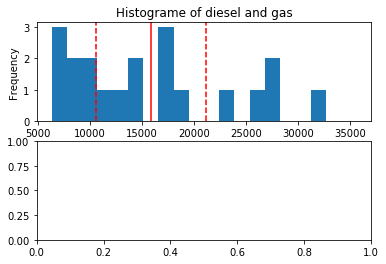

In [9]:
def hist_mean_ci(vec, t_test, bins):
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)
    
plot_t(diesel_cars_sample.loc[:,'price'], gas_cars_sample.loc[:,'price'], t_test_price_by_fuel, cols=['diesel','gas'])   

By plotting the the upper and lower confidence bounds shown as dashed lines we can see the mean of the population in the lower plot is outside the confidence interval of the difference of means of the population. 

NameError: name 'hist_plot' is not defined

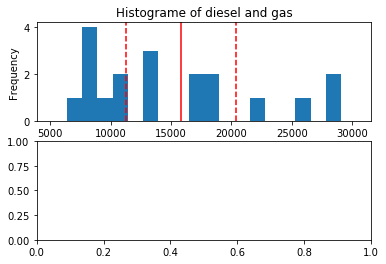

In [10]:
plot_t(diesel_cars_sample.loc[:,'price'], gas_cars_sample.loc[:,'price'], t_test_price_by_fuel, cols=['diesel','gas'])   

### Case: Price grouped by aspiration

#### Graphical Spot Check

We can take quick look at a box plot to get a general idea of the relative difference in means as well as other things like the spread of the values and outliers.

In [11]:
# take a stratified sample. there are only 36 cars with turbo aspiration so let's just take 36 std
turbo_asp_sample = auto_prices.loc[auto_prices['aspiration'] == 'turbo']
std_asp_sample = auto_prices.loc[auto_prices['aspiration'] == 'std'].sample(n=36)
total_asp_sample = turbo_asp_sample.append(std_asp_sample)

(0.0, 50000.0)

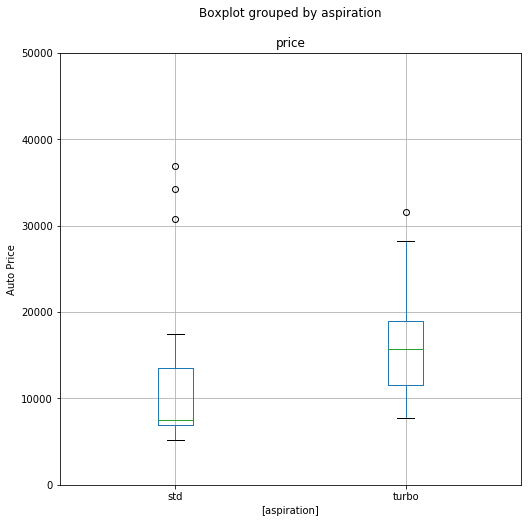

In [12]:
fig = plt.figure(figsize=(8, 8)) # define plot area
ax = fig.gca() # define axis 
total_asp_sample.loc[:,['price', 'aspiration']].boxplot(by = 'aspiration', ax = ax)
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

Again, as we can see the means are pretty far apart, but are they far enough apart as to be significant? Let's explore this formally.

#### The T-Test

In [13]:
t_test_price_by_aspiration = t_test(turbo_asp_sample.loc[:,'price'], std_asp_sample.loc[:,'price'], 0.05)
t_test_price_by_aspiration

DegFreedom      66.406584
Difference    5047.500000
Statistic        3.035681
PValue           0.003426
Low95CI       1728.143798
High95CI      8366.856202
dtype: float64

Once again we can make a few observations from the stastics above:

1. **Difference in means** is large.
2. **t-statistic is large and the p-value is very small**. There is a high chance that the difference in means is **significant**. 
3. The **95% confidence interval doesn't straddle 0**, indicating that both means don't fall within confidence interval of the difference of means of the population.

Based at the above statistics we **can reject the null hypothesis**. 

By plotting the the upper and lower confidence bounds shown as dashed lines we can see the mean of the population in the lower plot is outside the confidence interval of the difference of means of the population. 

NameError: name 'hist_plot' is not defined

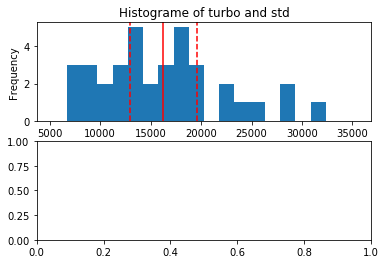

In [14]:
plot_t(turbo_asp_sample.loc[:,'price'], std_asp_sample.loc[:,'price'], t_test_price_by_aspiration, cols=['turbo','std'])   

### Case: Price grouped by rear vs front wheel drive.

#### Graphical Spot Check

We can take quick look at a box plot to get a general idea of the relative difference in means as well as other things like the spread of the values and outliers.

In [15]:
# take a stratified sample. there are only 71 cars with rear wheel drive so let's just take 71 front wheel
front_wheel_sample = auto_prices.loc[auto_prices['drive-wheels'] == 'fwd'].sample(n=71)
rear_wheel_sample = auto_prices.loc[auto_prices['drive-wheels'] == 'rwd']

total_drive_sample = front_wheel_sample.append(rear_wheel_sample)

(0.0, 50000.0)

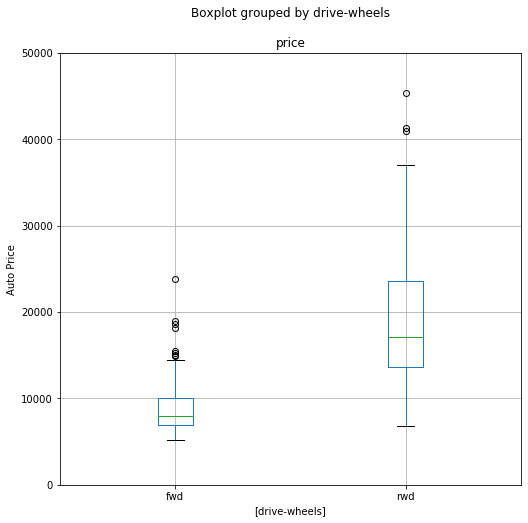

In [16]:
fig = plt.figure(figsize=(8, 8)) # define plot area
ax = fig.gca() # define axis 
total_drive_sample.loc[:,['price', 'drive-wheels']].boxplot(by = 'drive-wheels', ax = ax)
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

Again, as we can see the means are pretty far apart, but are they far enough apart as to be significant? Let's explore this formally.

#### The T-Test

In [17]:
t_test_price_by_drive = t_test(rear_wheel_sample.loc[:,'price'], front_wheel_sample.loc[:,'price'], 0.05)
t_test_price_by_drive

DegFreedom    9.245068e+01
Difference    1.090820e+04
Statistic     9.276971e+00
PValue        7.279519e-15
Low95CI       8.573037e+03
High95CI      1.324336e+04
dtype: float64

Once again we can make a few observations from the stastics above:

1. **Difference in means** is large.
2. **t-statistic is large and the p-value is very small**. There is a high chance that the difference in means is **significant**. 
3. The **95% confidence interval doesn't straddle 0**, indicating that both means don't fall within confidence interval of the difference of means of the population.

Based at the above statistics we **can reject the null hypothesis**. 

By plotting the the upper and lower confidence bounds shown as dashed lines we can see the mean of the population in the lower plot is outside the confidence interval of the difference of means of the population. 

NameError: name 'hist_plot' is not defined

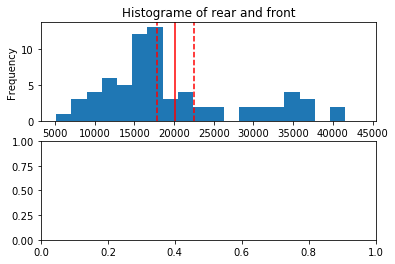

In [18]:
plot_t(rear_wheel_sample.loc[:,'price'], front_wheel_sample.loc[:,'price'], t_test_price_by_drive, cols=['rear','front'])   

## Step 3: Apply ANOVA and Tukey's HSD

### ANOVA

We're interesting in understanding the significance of body style with repspect to price.

**Null Hypothesis**: There is not significant difference in the mean price among all the body styles

**Alternative Hypothesis**: At least one body style has a statistically different mean price.

Let's create a box plot to gather a general sense of the variation of price between the body styles.

(0.0, 50000.0)

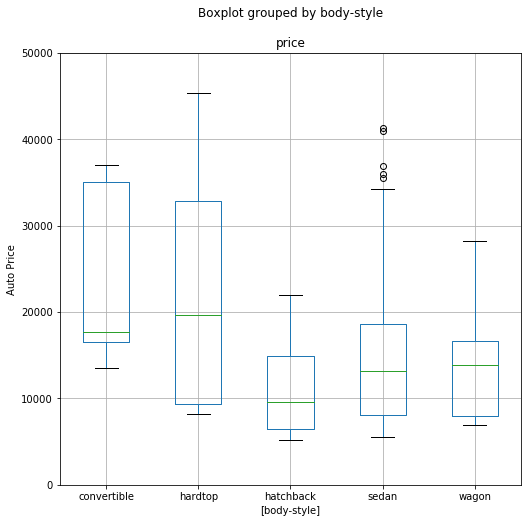

In [19]:
fig = plt.figure(figsize=(8, 8)) # define plot area
ax = fig.gca() # define axis 
total_drive_sample.loc[:,['price', 'body-style']].boxplot(by = 'body-style', ax = ax)
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

In [20]:
convertibles = auto_prices.loc[auto_prices['body-style'] == 'convertible']
hardtops = auto_prices.loc[auto_prices['body-style'] == 'hardtop']
hatchbacks = auto_prices.loc[auto_prices['body-style'] == 'hatchback']
sedans = auto_prices.loc[auto_prices['body-style'] == 'sedan']
wagons = auto_prices.loc[auto_prices['body-style'] == 'wagon']

f_statistic, p_value = ss.f_oneway(
    convertibles.loc[:,'price'], 
    hardtops.loc[:,'price'], 
    hatchbacks.loc[:,'price'], 
    sedans.loc[:,'price'], 
    wagons.loc[:,'price'])
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 9.004940478691072
P-value = 1.1106545919290286e-06


The F-Statistic is fairly large and the p-value is really really small. We can reject the null hypothesis that the five body styles same mean.

### Tukey's HSD 

In [21]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [22]:
all_prices = convertibles.loc[:,'price'].tolist() + hardtops.loc[:,'price'].tolist() + hatchbacks.loc[:,'price'].tolist() + sedans.loc[:,'price'].tolist() + wagons.loc[:,'price'].tolist()             
df = pd.DataFrame({'vals': all_prices,
                   'group': ['convertible']*6 + ['hardtop']*8 + ['hatchback']*63 + ['sedan']*94 + ['wagon']*24})
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group)
print(Tukey_HSD)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
   group1     group2    meandiff  p-adj     lower      upper    reject
----------------------------------------------------------------------
convertible   hardtop       318.0    0.9 -10784.1247 11420.1247  False
convertible hatchback -12126.5159 0.0018 -20909.4848 -3343.5469   True
convertible     sedan  -7430.7447 0.1295 -16086.8623   1225.373  False
convertible     wagon  -9390.3333 0.0497 -18773.3413    -7.3254   True
    hardtop hatchback -12444.5159  0.001 -20160.2385 -4728.7932   True
    hardtop     sedan  -7748.7447  0.042 -15319.7555  -177.7338   True
    hardtop     wagon  -9708.3333 0.0144 -18100.7508 -1315.9159   True
  hatchback     sedan   4695.7712 0.0014   1348.5969  8042.9455   True
  hatchback     wagon   2736.1825 0.5394  -2194.9472  7667.3123  False
      sedan     wagon  -1959.5887  0.754  -6661.0639  2741.8866  False
----------------------------------------------------------------------


Looking at the table above the difference in means between most of the body styles is significant and so can reject the null hypothesis. 

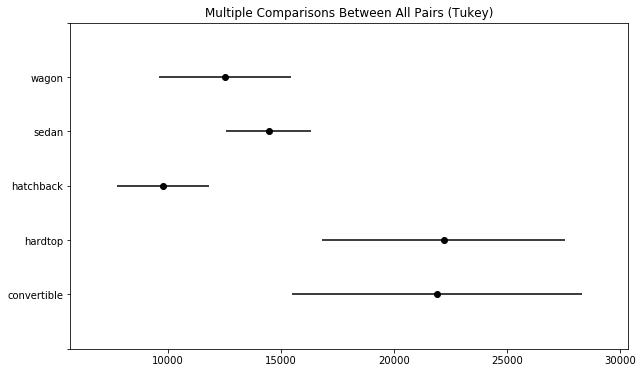

In [23]:
_ = Tukey_HSD.plot_simultaneous()

## Step 5: Graphical Exploration of Remaining Variables

In [24]:
auto_prices.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

### Price Variation Among Assigned Insurance Risk Rating (Symboling)

There's definitely price variation among different insurance risk rating, which almost any client is likely to want to explore further.

(0.0, 50000.0)

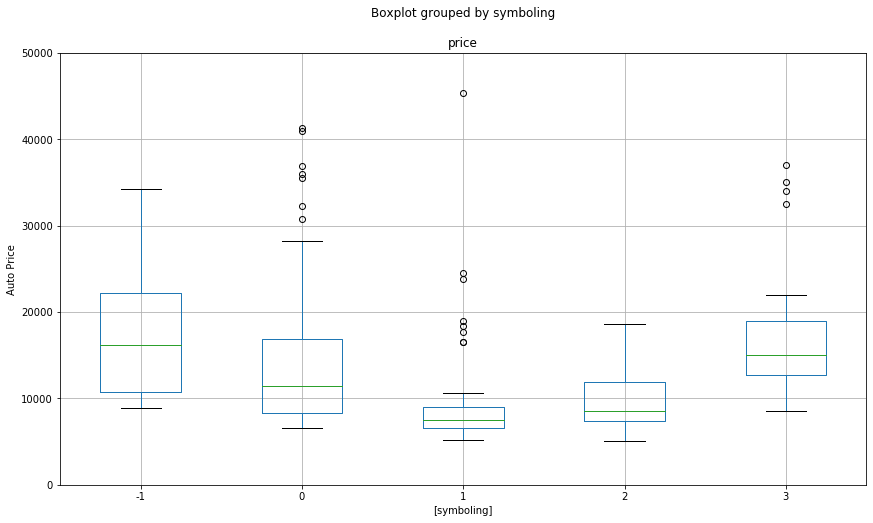

In [25]:
filtered_by_symboling = auto_prices[~auto_prices['symboling'].isin(['-2'])]
fig = plt.figure(figsize=(14, 8)) # define plot area
ax = fig.gca() # define axis 
filtered_by_symboling.loc[:,['price', 'symboling']].boxplot(by = 'symboling', ax = ax)
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

### Price Variation Two and Four Door Cars

Prices don't appeared to be influenced by the number of doors at all. So if our client "has a theory" about prices and four door cars cause their more likely to be "affordable family cars" we can throw that out the window. I'm just making this stuff up.

(0.0, 50000.0)

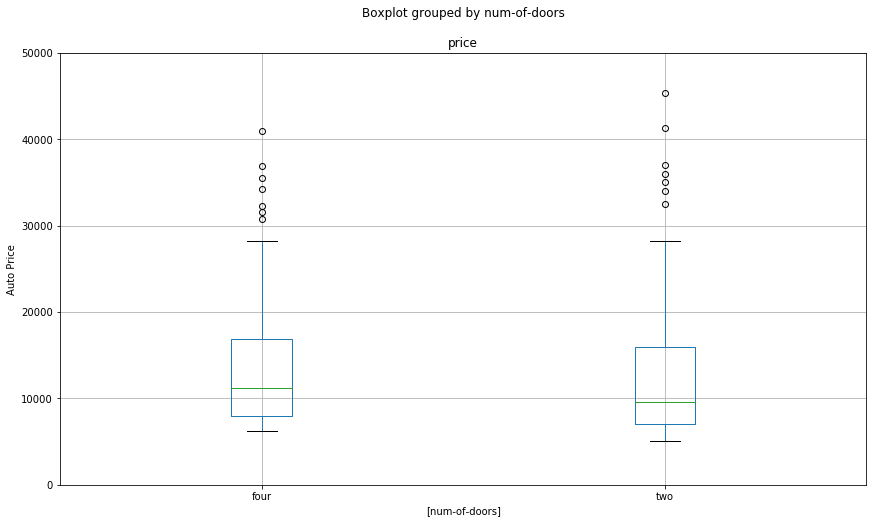

In [26]:
filtered_by_doors = auto_prices[~auto_prices['num-of-doors'].isin(['?'])]
fig = plt.figure(figsize=(14, 8)) # define plot area
ax = fig.gca() # define axis 
filtered_by_doors.loc[:,['price', 'num-of-doors']].boxplot(by = 'num-of-doors', ax = ax)
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

### Price Variation Among Fuel Systems

Prices maybe influenced by the fuel system of the car. It's not entirely clear from the box plot below, but there appears to be some possibility. It's worth exploring formally with the client if they want to pay me for that.

(0.0, 50000.0)

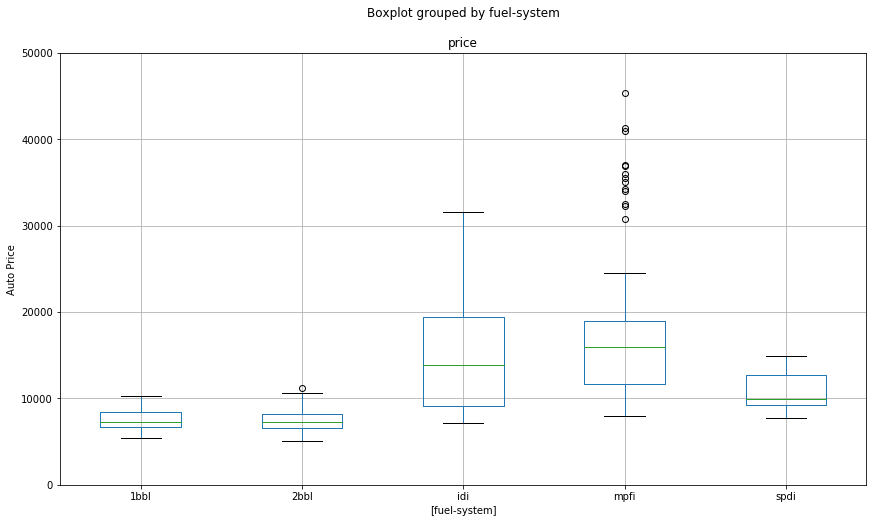

In [27]:
filtered_by_fuel_systems = auto_prices[~auto_prices['fuel-system'].isin(['spfi', 'mfi'])]
fig = plt.figure(figsize=(14, 8)) # define plot area
ax = fig.gca() # define axis 
filtered_by_fuel_systems.loc[:,['price', 'fuel-system']].boxplot(by = 'fuel-system', ax = ax)
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

### Price Variation Among Makes

Depending on our client they will care about how prices are influenced by the make of the car. We can see that variation in the box plot below.

(0.0, 50000.0)

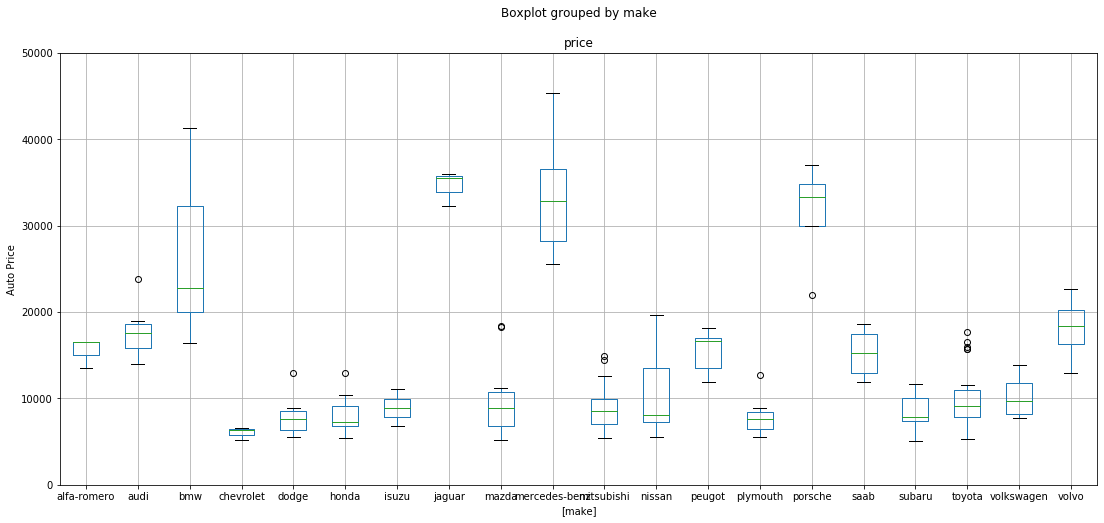

In [28]:
filtered_makes = auto_prices[~auto_prices.make.isin(['mercury', 'iszu'])]
fig = plt.figure(figsize=(18, 8)) # define plot area
ax = fig.gca() # define axis 
filtered_makes.loc[:,['price', 'make']].boxplot(by = 'make', ax = ax)
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis

### Engine Location

In [29]:
auto_prices.loc[:,'engine-location'].value_counts()

front    192
rear       3
Name: engine-location, dtype: int64

Given how few rear located engines there are this isn't enough data to explore this relationship

### Price Variation Among Number of Cylinders

As the box plot clearly demonstrates there's quite a bit of variation in prices among different number of cylinders in the car.

(0.0, 50000.0)

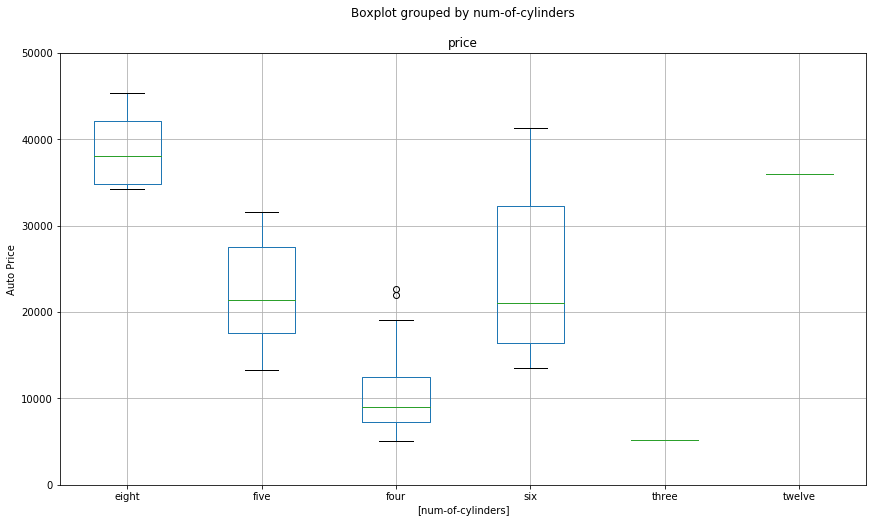

In [31]:
filtered_by_cylinders = auto_prices[~auto_prices['num-of-cylinders'].isin(['-2'])]
fig = plt.figure(figsize=(14, 8)) # define plot area
ax = fig.gca() # define axis 
filtered_by_cylinders.loc[:,['price', 'num-of-cylinders']].boxplot(by = 'num-of-cylinders', ax = ax)
ax.set_ylabel('Auto Price')# Set text for y axis
ax.set_ylim(0.0, 50000.0) # Set the limits of the y axis